In [ ]:
!pip install rdkit py3Dmol selfies

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 16.2 MB/s eta 0:00:00


In [1]:
import selfies as sf
from rdkit import Chem
from rdkit.Chem import AllChem # Import AllChem for 3D coordinate generation
import py3Dmol

def visualize_smiles_3d(smiles):
    """
    Generates a 3D visualization of a molecule from a SMILES string using py3Dmol.

    Args:
        smiles (str): A valid SMILES string.

    Returns:
        py3Dmol.view: A py3Dmol view object containing the 3D visualization.
                      Call .show() on this object to display the visualization.
    """
    # Create an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        print(f"Could not generate RDKit molecule from SMILES: {smiles}")
        return None

    # Add hydrogen atoms for 3D visualization
    mol = Chem.AddHs(mol)

    # Generate 3D coordinates
    # This is a crucial step for 3D visualization
    AllChem.EmbedMolecule(mol, AllChem.ETKDGv2())
    try:
        AllChem.MMFFOptimizeMolecule(mol) # Optional: Optimize the geometry
    except:
        print("Could not optimize molecule geometry.")
        pass # Continue even if optimization fails

    # Convert RDKit molecule to PDB format string
    # PDB is a common format for 3D molecular data
    pdb_string = Chem.MolToPDBBlock(mol)

    # Create a py3Dmol view
    view = py3Dmol.view(width=400, height=400)

    # Add the molecule to the view from the PDB string
    view.addModel(pdb_string, 'pdb')

    # Style the molecule representation (e.g., stick, sphere, cartoon)
    view.setStyle({'stick':{}})

    # Zoom to fit the molecule in the view
    view.zoomTo()

    return view


def tokenize_selfies(smiles):
    """
    Convert a SMILES string to a list of SELFIES tokens.

    Args:
        smiles (str): A valid SMILES string.

    Returns:
        List[str]: A list of SELFIES tokens (e.g. ["[C]", "[=O]", "[Branch1]", ...]).

    Example:
        >>> tokenize_selfies("CCO")
        ["[C]", "[C]", "[O]"]
    """
    # 1. Encode the SMILES into a single SELFIES string
    selfies_str = sf.encoder(smiles)

    # 2. Split the SELFIES string into tokens; sf.split_selfies returns a generator, so wrap in list()
    tokens = list(sf.split_selfies(selfies_str))

    return tokens


def detokenize_selfies(tokens):
    """
    Reconstruct a SMILES string from a list of SELFIES tokens.

    Args:
        tokens (List[str]): A list of SELFIES tokens (e.g. ["[C]", "[C]", "[O]"]).

    Returns:
        str: The reconstructed SMILES string.

    Example:
        >>> detokenize_selfies(["[C]", "[C]", "[O]"])
        "CCO"
    """
    # 1. Join the tokens back into one SELFIES string
    reconstructed_selfies = "".join(tokens)

    # 2. Decode the SELFIES back to SMILES
    smiles = sf.decoder(reconstructed_selfies)

    return smiles


# Original molecule
orig_smiles = "Cc1c(C)n(Cc2cc(O[C@@H](C)C(=O)O)ccc2Cl)c2ccc(C(=O)N[C@@H](C)c3cccc(C(C)C)c3)cc12"

# 1) Tokenize → get SELFIES tokens
tokens = tokenize_selfies(orig_smiles)
print("SELFIES tokens:", tokens)
# e.g. ["[C]", "[c]", "[=C]", "[Branch1]", "[C]", "[n]", ... ]

# 2) (Optionally) manipulate tokens here…

# 3) Detokenize → get SMILES back
reconstructed_smiles = detokenize_selfies(tokens)
print("Reconstructed SMILES:", reconstructed_smiles)
view = visualize_smiles_3d(reconstructed_smiles)
view.show()
# 4) Verify equivalence (as substructure or exact match, depending on tautomerism/aromaticity)
orig_mol = Chem.MolFromSmiles(orig_smiles)
recon_mol = Chem.MolFromSmiles(reconstructed_smiles)
assert recon_mol is not None
print("Reconstruction successful?", orig_mol.HasSubstructMatch(recon_mol))



SELFIES tokens: ['[C]', '[C]', '[=C]', '[Branch1]', '[C]', '[C]', '[N]', '[Branch2]', '[Ring1]', '[#Branch1]', '[C]', '[C]', '[=C]', '[C]', '[Branch1]', '[O]', '[O]', '[C@@H1]', '[Branch1]', '[C]', '[C]', '[C]', '[=Branch1]', '[C]', '[=O]', '[O]', '[=C]', '[C]', '[=C]', '[Ring1]', '[N]', '[Cl]', '[C]', '[=C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[=Branch2]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C@@H1]', '[Branch1]', '[C]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[Branch1]', '[=Branch1]', '[C]', '[Branch1]', '[C]', '[C]', '[C]', '[=C]', '[Ring1]', '[=Branch2]', '[C]', '[=C]', '[Ring2]', '[Ring2]', '[=Branch1]', '[Ring2]', '[Ring1]', '[Ring2]']
Reconstructed SMILES: CC1=C(C)N(CC2=CC(O[C@@H1](C)C(=O)O)=CC=C2Cl)C3=CC=C(C(=O)N[C@@H1](C)C4=CC=CC(C(C)C)=C4)C=C13


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Reconstruction successful? True


In [2]:
# Assuming your text file is named 'molecules.txt' and has the format:
# SMILES Name
# CCO ethanol
# C1=CC=C(C=C1)C=O benzaldehyde

smiles_data = []
file_path = 'smilelist.txt' # Replace with the actual path to your file

try:
    with open(file_path, 'r') as f:
        for line in f:
            # Strip leading/trailing whitespace and split the line by space
            parts = line.strip().split()
            if len(parts) >= 1:
                # The first part is the SMILES, the rest is the name (in case of multi-word names)
                smiles = parts[0]
                name = " ".join(parts[1:])
                smiles_data.append((smiles, name))
            else:
                print(f"Skipping invalid line: {line.strip()}")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# Now smiles_data is a list of tuples, e.g., [('CCO', 'ethanol'), ('C1=CC=C(C=C1)C=O', 'benzaldehyde')]
# You can access the SMILES and name for each entry:
# for smiles, name in smiles_data:
#     print(f"SMILES: {smiles}, Name: {name}")

# If you still need a smiles_list containing only the SMILES strings:
# smiles_list = [entry[0] for entry in smiles_data]

Skipping invalid line: 


In [3]:
smiles_list = [entry[0] for entry in smiles_data]
print(len(smiles_list))
print((smiles_list[0]))

8705
CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(O)=O)NC(=O)CNC(=O)[C@H](CC(N)=O)NC(=O)CNC(=O)CNC(=O)CNC(=O)CNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=O)[C@@H]1CCCN1C(=O)[C@H](N)CC1=CC=CC=C1)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CCC(O)=O)C(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)N[C@@H](CC(C)C)C(O)=O


In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdFingerprintGenerator
import rdkit.DataStructs # Import DataStructs
import py3Dmol
import random
import numpy as np
import selfies as sf
from selfies import EncoderError

# The tokenize_selfies function remains the same
def tokenize_selfies(smiles):
    """
    Convert a SMILES string to a list of SELFIES tokens.

    Args:
        smiles (str): A valid SMILES string.

    Returns:
        List[str] or None: A list of SELFIES tokens if successful,
                           or None if an EncoderError occurs.
    """
    try:
        selfies_str = sf.encoder(smiles, strict=False)
        tokens = list(sf.split_selfies(selfies_str))
        return tokens
    except EncoderError as e:
        print(f"Error encoding SMILES '{smiles}': {e}")
        return None # Return None to indicate failure


# Initialize a list to store successfully tokenized SMILES
smiles_tokens_from_smiles = []
# Initialize a new list to store the SMILES that were successfully tokenized
successful_smiles_list = []

# Iterate through the original smiles_list
for smi in smiles_list:
    # Attempt to tokenize the current SMILES
    bin_tokens = tokenize_selfies(smi)

    # Check if the tokenization was successful (bin_tokens is not None)
    if bin_tokens is not None:
        # If successful, append the tokens to the tokens list
        smiles_tokens_from_smiles.append(bin_tokens)
        # And append the original SMILES to the list of successful SMILES
        successful_smiles_list.append(smi)

# Now update the original smiles_list to only contain the successful ones
smiles_list = successful_smiles_list

print(f"Original number of SMILES: {len(smiles_list) + (len(smiles_data) - len(smiles_list))}") # Print original count (approx)
print(f"Successfully tokenized {len(smiles_tokens_from_smiles)} SMILES strings.")
print(f"Remaining SMILES in smiles_list: {len(smiles_list)}")

Error encoding SMILES 'C[C@@H](O)[C@@H](N)C1=NC(Cc2cnc3cccc(F)c23)=C(O)N1CC(O)=O': kekulization failed
	SMILES: C[C@@H](O)[C@@H](N)C1=NC(Cc2cnc3cccc(F)c23)=C(O)N1CC(O)=O
Error encoding SMILES 'C1(N(C(=O)CC1)CCC12[Fe]3456789%10C%11C3=C4C5=C6%11)=O.C7(C8=C19)=C2%10': failed to parse input
	SMILES: C1(N(C(=O)CC1)CCC12[Fe]3456789%10C%11C3=C4C5=C6%11)=O.C7(C8=C19)=C2%10
Error encoding SMILES 'NC(=[NH2+])c1ccc2nc(Cc3nc4ccc(cc4n3)C(N)=[NH2+])nc2c1': kekulization failed
	SMILES: NC(=[NH2+])c1ccc2nc(Cc3nc4ccc(cc4n3)C(N)=[NH2+])nc2c1
Error encoding SMILES 'Clc1nc(Br)nc2ncnc12': kekulization failed
	SMILES: Clc1nc(Br)nc2ncnc12
Error encoding SMILES 'NC(=[NH2+])c1ccc2nc(nc2c1)C1=CC=CC(C2=CC=CC=C2)=C1[O-]': kekulization failed
	SMILES: NC(=[NH2+])c1ccc2nc(nc2c1)C1=CC=CC(C2=CC=CC=C2)=C1[O-]
Error encoding SMILES 'CC(C)(CO[P@](O)(=O)O[P@@](O)(=O)OC[C@@H]1O[C@H]([C@H](O)[C@H]1OP(O)(O)=O)N1C=NC2=C1N=CN=C2N)[C@@H](O)C(=O)NCCC(=O)NCCSCCCCC(=O)NCCc1cnc2ccccc12': kekulization failed
	SMILES: CC(C)(CO[P@](O

In [5]:
print(len(smiles_tokens_from_smiles))

8600


In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, GraphDescriptors
import numpy as np
import selfies as sf # Make sure selfies is imported as it's used in tokenize_selfies

# The tokenize_selfies function remains the same (assuming it's defined elsewhere in the notebook)
# from selfies import EncoderError # Also assuming EncoderError is imported

# === Step 1: Calculate raw molecular properties and atom-level features ===
raw_mol_properties = []   # List of only molecular-level descriptor vectors
atom_features_dict = {}   # Map: SMILES → atomic features
# Create a new list to store SMILES for which properties were successfully calculated
smiles_with_properties = []

for smiles in smiles_list: # Iterate over the list of SMILES that were successfully tokenized
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Skipping invalid SMILES for property calculation: {smiles}")
        continue # Skip this SMILES if RDKit cannot parse it

    # --- Molecular descriptors ---
    mol_props = [
        Descriptors.MolWt(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.TPSA(mol),
        mol.GetNumAtoms()
    ]
    raw_mol_properties.append(mol_props)
    smiles_with_properties.append(smiles) # Add SMILES to the new list

    # --- Atomic descriptors ---
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append({
            "atom_index": atom.GetIdx(),
            "atomic_num": atom.GetAtomicNum(),
            "degree": atom.GetDegree()
        })

    atom_features_dict[smiles] = atom_features

# Convert raw molecular properties to NumPy array
# This array will now have the same number of rows as smiles_with_properties
raw_properties_array = np.array(raw_mol_properties)

# === Step 2: Normalize molecular properties ===
def min_max_normalize(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    denom = max_vals - min_vals
    denom[denom == 0] = 1.0
    return (data - min_vals) / denom

def tanh_normalize(data, scale_factor=0.1):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1.0
    standardized = (data - mean) / std
    normalized = np.tanh(scale_factor * standardized)
    return (normalized + 1) / 2

# Only attempt to normalize if there are properties to normalize
if raw_properties_array.shape[0] > 0:
    normalized_properties_array = min_max_normalize(raw_properties_array)
else:
    normalized_properties_array = np.array([]) # Handle case with no valid molecules


# === Step 3: Assemble the final data dictionary ===
property_names = [
    "MolecularWeight",
    "NumHDonors",
    "NumHAcceptors",
    "NumRotatableBonds",
    "TPSA",
    "NumAtoms"
]

molecule_data = {}

# Iterate over the list of SMILES for which properties were calculated
for i, smiles in enumerate(smiles_with_properties):
    mol = Chem.MolFromSmiles(smiles) # Re-parse the molecule for completeness, though it should succeed here
    if mol is None:
        continue # Should not happen based on smiles_with_properties list

    # Find the corresponding tokens. Assumes smiles_tokens_from_smiles is aligned with the original smiles_list
    # A more robust way would be to create a dictionary from original smiles to its tokens earlier
    # For now, we'll stick to the original structure but acknowledge potential alignment issues
    # if the filtering in the tokenization step was not perfect.
    # A better approach would be to build smiles_tokens_from_smiles as a dictionary {smiles: tokens}
    # or ensure smiles_list is updated *after* property calculation too.

    # Assuming smiles_tokens_from_smiles is still aligned with the original smiles_list order
    # Find the index of the current 'smiles' in the original smiles_list to get its tokens
    try:
         original_index = smiles_list.index(smiles)
         current_smiles_tokens = smiles_tokens_from_smiles[original_index]
    except ValueError:
         # This means a SMILES in smiles_with_properties was not in the original smiles_list, which is unexpected
         print(f"Warning: SMILES '{smiles}' not found in original smiles_list. Skipping token assignment.")
         current_smiles_tokens = None


    molecular_properties = {
        prop_name: normalized_properties_array[i, j]
        for j, prop_name in enumerate(property_names)
    }

    # Ensure atomic features exist for this SMILES
    current_atom_features = atom_features_dict.get(smiles, [])

    molecule_data[smiles] = {
        "smiles": smiles,
        "original_mol": mol,
        "scaffold_fp": current_smiles_tokens, # Using tokens as scaffold_fp placeholder
        "molecular_properties": molecular_properties,
        "atom_features": current_atom_features
    }

print(f"Processed {len(molecule_data)} molecules for final data structure.")

[13:27:40] Explicit valence for atom # 17 O, 2, is greater than permitted
[13:27:40] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[13:27:40] Explicit valence for atom # 16 N, 4, is greater than permitted


Skipping invalid SMILES for property calculation: NC(=O)[C@H]1C=[N+](C=CC1=O)[C@@H]1O[C@@H](CO[P@](O)(=[O-])O[P@@](O)(=O)OC[C@@H]2O[C@H]([C@H](OP(O)(O)=O)[C@H]2O)N2C=NC3=C2N=CN=C3N)[C@H](O)[C@H]1O
Skipping invalid SMILES for property calculation: NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O
Skipping invalid SMILES for property calculation: CCOC1=CC=CC=C1SC1=CC=C(C=C1[N](O)=O)C1=CC=NC(=C1)N1CCN(CC1)C(C)=O


[13:27:40] Explicit valence for atom # 8 N, 3, is greater than permitted
[13:27:40] Explicit valence for atom # 53 N, 4, is greater than permitted


Skipping invalid SMILES for property calculation: CC1=C(C=C)C2=CC3=[N-]4C(=CC5=C(CCC(O)=O)C(C)=C6N5[Zn++]44N2C1=CC1=[N-]4C(C(C)=C1C=C)=C6O)C(CCC(O)=O)=C3C
Skipping invalid SMILES for property calculation: CC(C)(CO[P@](O)(=O)O[P@@](O)(=O)OC[C@@H]1O[C@H]([C@H](O)[C@H]1OP(O)(O)=O)N1C=NC2=C1N=CN=C2N)[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CCC[N](O)=O


[13:27:40] Explicit valence for atom # 3 Ga, 6, is greater than permitted
[13:27:41] Explicit valence for atom # 6 B, 4, is greater than permitted
[13:27:41] Explicit valence for atom # 27 N, 4, is greater than permitted


Skipping invalid SMILES for property calculation: CC1=[O][Ga]2345ON1CCC[C@H]1NC(=O)CNC(=O)[C@H](CO)NC(=O)CNC(=O)[C@H](CCCN(O2)C(C)=[O]3)NC(=O)C(CCCN(O4)C(C)=[O]5)NC1=O
Skipping invalid SMILES for property calculation: N[C@@H](CSCC[B](O)(O)O)C(O)=O
Skipping invalid SMILES for property calculation: NC1=NC=NC2=C1N=CN2[C@@H]1O[C@@H](\C=C\CNC(=O)C2=CC(=CC(O)=C2O)[N](O)=O)[C@H](O)[C@H]1O


[13:27:41] Explicit valence for atom # 0 O, 3, is greater than permitted
[13:27:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[13:27:41] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:27:41] Explicit valence for atom # 6 Be, 4, is greater than permitted
[13:27:41] Explicit valence for atom # 0 O, 1, is greater than permitted
[13:27:41] Explicit valence for atom # 1 Al, 4, is greater than permitted


Skipping invalid SMILES for property calculation: [O]#C[Re+]1(C#[O])(C#[O])[N]2=CC=CC3=C2C2=C(C=CC=[N]12)C=C3
Skipping invalid SMILES for property calculation: O[N](=O)C1=CC(=C(C=C1N(CCBr)CCBr)C(=O)NCC(=O)C=O)[N](O)=O
Skipping invalid SMILES for property calculation: N[C@@H](C[C@H](O)O[Be](F)(F)F)C(O)=O
Skipping invalid SMILES for property calculation: [O--][Mo+6]123([O--])[O--][Mo+6]45([O--])([O--])[O--][Mo+6]67([O--])([O--])[O--][Mo+6]89([O--])([O--])[O--][Mo+6]%10%11([O--])([O--])[O--][Mo+6]%12([O--])([O--])([O--]1)[O--]%10[Mo+6]([O--]2)([O--]8)([O--]46)([O--]35%12)[O--]79%11
Skipping invalid SMILES for property calculation: F[Al](F)(F)[F-]


[13:27:42] Explicit valence for atom # 13 Be, 4, is greater than permitted


Skipping invalid SMILES for property calculation: CN(CCO[P@](O)(=O)O[P@@](O)(=O)O[Be-](F)(F)F)C1=CC=CC=C1[N+]([O-])=O


[13:27:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


Processed 8476 molecules for final data structure.


In [7]:
first_smiles = smiles_list[1]
print(len(molecule_data))

8476


In [8]:
# Remove entries where any value in the dict is None
print(len(molecule_data))
molecule_data = {
    k: v for k, v in molecule_data.items()
    if v is not None and not any(val is None for val in v.values())
}
keys_to_check = ["original_mol", "scaffold_fp"]

molecule_data = {
    k: v for k, v in molecule_data.items()
    if all(v.get(key) is not None for key in keys_to_check)
}

print(len(molecule_data))

8476
8476


In [9]:
from collections import defaultdict
import numpy as np
from rdkit import Chem  # Make sure RDKit is installed
# Assume detokenize_selfies and visualize_smiles_3d are defined elsewhere

# Step 1: Collect all unique tokens (strings) from scaffold_fp
unique_tokens = set()
max_len = 0  # Start with 0

for data in molecule_data.values():
    if data["scaffold_fp"]:
        unique_tokens.update(data["scaffold_fp"])
        max_len = max(max_len, len(data["scaffold_fp"]))  # Update max length

# Step 2: Build token-to-index and index-to-token maps
token_to_idx = {tok: i+1 for i, tok in enumerate(sorted(unique_tokens))}  # index from 1
idx_to_token = {i: tok for tok, i in token_to_idx.items()}
idx_to_token[0] = "<PAD>"  # Padding token at index 0

# Step 3: Prepare property keys and lists
property_keys = [
    "MolecularWeight", "NumHDonors", "NumHAcceptors",
    "NumRotatableBonds", "TPSA", "NumAtoms"
]

X_properties = []
Y_token_indices_padded = []
valid_keys = []

for smi, data in molecule_data.items():
    props = data.get("molecular_properties")
    scaffold_fp = data.get("scaffold_fp")

    if scaffold_fp is None or props is None:
        continue

    token_indices = [token_to_idx.get(tok, 0) for tok in scaffold_fp]

    # Apply padding based on dynamically computed max_len
    if len(token_indices) < max_len:
        padded = token_indices + [0] * (max_len - len(token_indices))
    else:
        padded = token_indices[:max_len]

    X_properties.append([props[k] for k in property_keys])
    Y_token_indices_padded.append(padded)
    valid_keys.append(smi)

In [10]:
X_properties = np.array(X_properties, dtype=np.float32)
Y_properties = np.array(Y_token_indices_padded, dtype=np.int32)

print(X_properties.shape)
print(Y_properties.shape) # Print the shape of the padded array


(8476, 6)
(8476, 837)


In [11]:
first_smiles = smiles_list[45]
molecule_info = molecule_data[first_smiles]

# Access the 'molecular_properties' dictionary within that info
print(len(molecule_info['scaffold_fp']))

51


In [12]:
!pip install scikit-learn

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import selfies as sf
from rdkit import Chem
import py3Dmol

# Hyperparameters
d_model = 256
nhead = 8
num_layers = 3
dim_feedforward = 512
dropout = 0.1
batch_size = 64
learning_rate = 1e-4
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Update Vocabulary with special tokens
original_token_count = len(token_to_idx)
sos_token = "<SOS>"
eos_token = "<EOS>"
pad_token = "<PAD>"

# Add special tokens to vocabulary
token_to_idx[sos_token] = original_token_count + 1
token_to_idx[eos_token] = original_token_count + 2
# Note: PAD token is already at index 0

idx_to_token[original_token_count + 1] = sos_token
idx_to_token[original_token_count + 2] = eos_token
idx_to_token[0] = pad_token

vocab_size = original_token_count + 3  # Includes PAD (0), SOS, and EOS
sos_token_id = token_to_idx[sos_token]
eos_token_id = token_to_idx[eos_token]
pad_token_id = 0

import pickle

# Save vocabulary to vocab.pkl
vocab_info = {
    'token_to_idx': token_to_idx,
    'idx_to_token': idx_to_token,
    'sos_token_id': sos_token_id,
    'eos_token_id': eos_token_id,
    'pad_token_id': pad_token_id
}

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab_info, f)

print("✅ Saved vocabulary to vocab.pkl")

print(f"Vocabulary size: {vocab_size}")
print(f"SOS token ID: {sos_token_id}")
print(f"EOS token ID: {eos_token_id}")
print(f"PAD token ID: {pad_token_id}")

# 2. Positional Encoding Module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:x.size(1)].transpose(0, 1)
        return self.dropout(x)

# 3. Corrected Transformer Model
class MolecularTransformer(nn.Module):
    def __init__(self, property_dim, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, max_seq_len=80):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # RNN-based encoder for fragment-wise molecular properties
        self.rnn_encoder = nn.GRU(
            input_size=property_dim,   # Or dim per fragment if using sequence
            hidden_size=d_model,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )

        # Token embedding + position encoding
        self.token_embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.output_projection = nn.Linear(d_model, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.token_embed.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)

    def create_padding_mask(self, tokens):
        return (tokens == pad_token_id)

    def create_causal_mask(self, size):
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask

    def forward(self, properties, target_tokens=None):
        batch_size = properties.size(0)

        # Handle RNN input: if 2D, expand to 3D with sequence length = 1
        if properties.dim() == 2:
            properties = properties.unsqueeze(1)  # [batch, 1, property_dim]

        rnn_output, hidden = self.rnn_encoder(properties)  # hidden: [1, batch, d_model]
        memory = hidden.transpose(0, 1)  # [batch, 1, d_model]

        if target_tokens is not None:
            seq_len = target_tokens.size(1)
            memory = memory.expand(batch_size, seq_len, self.d_model)

            token_embeds = self.token_embed(target_tokens) * math.sqrt(self.d_model)
            token_embeds = self.pos_encoder(token_embeds)

            tgt_padding_mask = self.create_padding_mask(target_tokens)
            tgt_causal_mask = self.create_causal_mask(seq_len).to(target_tokens.device)

            output = self.transformer_decoder(
                tgt=token_embeds,
                memory=memory,
                tgt_mask=tgt_causal_mask,
                tgt_key_padding_mask=tgt_padding_mask
            )

            logits = self.output_projection(output)
            return logits

        else:
            return self.generate(properties.squeeze(1))  # for inference


    def generate(self, properties, max_len=max_len, temperature=1.0):
        # If properties is 2D, expand to 3D for RNN input
        if properties.dim() == 2:
            properties = properties.unsqueeze(1)  # [batch, 1, property_dim]

        # Pass through RNN encoder
        _, hidden = self.rnn_encoder(properties)
        memory = hidden.transpose(0, 1)  # [batch, 1, d_model]

        batch_size = properties.size(0)
        device = properties.device

        generated_tokens = torch.full((batch_size, 1), sos_token_id, dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            token_embeds = self.token_embed(generated_tokens) * math.sqrt(self.d_model)
            token_embeds = self.pos_encoder(token_embeds)

            tgt_mask = self.create_causal_mask(generated_tokens.size(1)).to(device)
            tgt_padding_mask = self.create_padding_mask(generated_tokens)

            output = self.transformer_decoder(
                tgt=token_embeds,
                memory=memory.expand(batch_size, token_embeds.size(1), self.d_model),
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_padding_mask
            )

            logits = self.output_projection(output[:, -1, :])  # [batch, vocab_size]
            logits = logits / temperature
            next_token = torch.argmax(logits, dim=-1, keepdim=True)  # [batch, 1]

            generated_tokens = torch.cat([generated_tokens, next_token], dim=1)

            if (next_token == eos_token_id).all():
                break

        return generated_tokens

✅ Saved vocabulary to vocab.pkl
Vocabulary size: 201
SOS token ID: 199
EOS token ID: 200
PAD token ID: 0


In [14]:
def prepare_target_sequences(Y_token_indices, max_len=max_len):
    """Add EOS tokens to target sequences and prepare for training"""
    batch_size, seq_len = Y_token_indices.shape

    # Create new array with space for EOS token
    new_targets = np.zeros((batch_size, max_len), dtype=np.int32)

    for i in range(batch_size):
        # Find the end of actual sequence (first padding token)
        actual_seq = Y_token_indices[i]
        end_idx = np.where(actual_seq == 0)[0]

        if len(end_idx) > 0:
            # Insert EOS before padding
            seq_end = end_idx[0]
            new_targets[i, :seq_end] = actual_seq[:seq_end]
            if seq_end < max_len:
                new_targets[i, seq_end] = eos_token_id
        else:
            # No padding found, use entire sequence
            new_targets[i, :min(seq_len, max_len-1)] = actual_seq[:min(seq_len, max_len-1)]
            if max_len > seq_len:
                new_targets[i, seq_len] = eos_token_id

    return new_targets

# 5. Enhanced Training function with early stopping and additional metrics
# 5. Enhanced Training function with early stopping and additional metrics
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, patience=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Metrics tracking
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    train_mses = []
    val_mses = []
    train_accuracies = []
    val_accuracies = []

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopped = False

    print(f"🚀 Starting training with early stopping (patience: {patience})")
    print("=" * 70)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_predictions = []
        train_targets = []
        num_batches = 0

        for properties, targets in train_loader:
            properties, targets = properties.to(device), targets.to(device)

            # Prepare decoder input (shift right with SOS)
            decoder_input = torch.full_like(targets, pad_token_id)
            decoder_input[:, 0] = sos_token_id
            decoder_input[:, 1:] = targets[:, :-1]

            optimizer.zero_grad()

            # Forward pass
            logits = model(properties, decoder_input)

            # Calculate loss
            # Loss calculation should ignore the padding index
            loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            num_batches += 1

            # Calculate accuracy and collect predictions for MAE/MSE
            predictions = torch.argmax(logits, dim=-1)

            # Only consider non-padding tokens in targets
            mask = (targets != pad_token_id)
            if mask.sum() > 0:
                train_correct += (predictions[mask] == targets[mask]).sum().item()
                train_total += mask.sum().item()

                # Collect predictions and targets for MAE/MSE (excluding padding)
                # Ensure targets and predictions are flattened and non-padding
                train_predictions.extend(predictions[mask].cpu().numpy())
                train_targets.extend(targets[mask].cpu().numpy())


        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_predictions = []
        val_targets_list = []
        val_batches = 0

        with torch.no_grad():
            for properties, targets in val_loader:
                properties, targets = properties.to(device), targets.to(device)

                decoder_input = torch.full_like(targets, pad_token_id)
                decoder_input[:, 0] = sos_token_id
                decoder_input[:, 1:] = targets[:, :-1]

                logits = model(properties, decoder_input)
                # Loss calculation should ignore the padding index
                loss = criterion(logits.reshape(-1, vocab_size), targets.reshape(-1))

                val_loss += loss.item()
                val_batches += 1

                # Calculate validation metrics
                predictions = torch.argmax(logits, dim=-1)
                mask = (targets != pad_token_id)

                if mask.sum() > 0:
                    val_correct += (predictions[mask] == targets[mask]).sum().item()
                    val_total += mask.sum().item()

                    # Collect predictions and targets for MAE/MSE (excluding padding)
                    val_predictions.extend(predictions[mask].cpu().numpy())
                    val_targets_list.extend(targets[mask].cpu().numpy())

        # Calculate average metrics
        avg_train_loss = train_loss / num_batches
        avg_val_loss = val_loss / val_batches

        train_accuracy = (train_correct / train_total) * 100 if train_total > 0 else 0
        val_accuracy = (val_correct / val_total) * 100 if val_total > 0 else 0

        # Calculate MAE and MSE
        train_mae = mean_absolute_error(train_targets, train_predictions) if train_targets else 0
        train_mse = mean_squared_error(train_targets, train_predictions) if train_targets else 0
        val_mae = mean_absolute_error(val_targets_list, val_predictions) if val_targets_list else 0
        val_mse = mean_squared_error(val_targets_list, val_predictions) if val_targets_list else 0


        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_maes.append(train_mae)
        val_maes.append(val_mae)
        train_mses.append(train_mse)
        val_mses.append(val_mse)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)


        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']


        # Print epoch results
        print(f'Epoch {epoch+1:3d}/{num_epochs}:')
        print(f'  Loss     - Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}')
        print(f'  Accuracy - Train: {train_accuracy:.2f}% | Val: {val_accuracy:.2f}%')
        print(f'  MAE      - Train: {train_mae:.4f} | Val: {val_mae:.4f}')
        print(f'  MSE      - Train: {train_mse:.4f} | Val: {val_mse:.4f}')
        print(f'  LR: {current_lr:.2e}')


        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the model checkpoint including optimizer and scheduler states
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_loss': best_val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_maes': train_maes,
                'val_maes': val_maes,
                'train_mses': train_mses,
                'val_mses': val_mses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'vocab_info': vocab_info,
                'normalization_params': {
                    'min_vals': np.min(raw_properties_array, axis=0),
                    'max_vals': np.max(raw_properties_array, axis=0)
                }
            }, 'best_molecular_transformer.pth')

            print('  ✅ Saved best model (Val loss improved)')
        else:
            patience_counter += 1
            print(f'  ⏳ No improvement for {patience_counter}/{patience} epochs')

            if patience_counter >= patience:
                print(f'\n🛑 Early stopping triggered! No improvement for {patience} epochs.')
                early_stopped = True
                break

        print('-' * 70)

    # Training completion message
    if early_stopped:
        print(f'🎯 Training stopped early at epoch {epoch+1}')
    else:
        print('🎉 Training completed all epochs!')

    print(f'📊 Best validation loss: {best_val_loss:.4f}')

    # Plot comprehensive training curves
    plot_training_metrics(train_losses, val_losses, train_maes, val_maes,
                         train_mses, val_mses, train_accuracies, val_accuracies)


    # Load best model state dictionary to ensure the returned model is the best one
    # ADDED weights_only=False here
    print('\n📂 Loading best model...')
    checkpoint = torch.load('best_molecular_transformer.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_maes': train_maes,
        'val_maes': val_maes,
        'train_mses': train_mses,
        'val_mses': val_mses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss,
        'early_stopped': early_stopped,
        'total_epochs': epoch + 1
    }

In [15]:
# 4. Updated data preparation with EOS tokens

def plot_training_metrics(train_losses, val_losses, train_maes, val_maes,
                         train_mses, val_mses, train_accuracies, val_accuracies):
    """Plot comprehensive training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Dashboard', fontsize=16, fontweight='bold')

    # Loss plot
    axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.8, linewidth=2)
    axes[0, 0].plot(val_losses, label='Val Loss', alpha=0.8, linewidth=2)
    axes[0, 0].set_title('Loss Over Time')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(train_accuracies, label='Train Accuracy', alpha=0.8, linewidth=2)
    axes[0, 1].plot(val_accuracies, label='Val Accuracy', alpha=0.8, linewidth=2)
    axes[0, 1].set_title('Token Accuracy Over Time')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # MAE plot
    axes[1, 0].plot(train_maes, label='Train MAE', alpha=0.8, linewidth=2)
    axes[1, 0].plot(val_maes, label='Val MAE', alpha=0.8, linewidth=2)
    axes[1, 0].set_title('Mean Absolute Error Over Time')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # MSE plot
    axes[1, 1].plot(train_mses, label='Train MSE', alpha=0.8, linewidth=2)
    axes[1, 1].plot(val_mses, label='Val MSE', alpha=0.8, linewidth=2)
    axes[1, 1].set_title('Mean Squared Error Over Time')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('MSE')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics summary
    print("\n📈 Final Metrics Summary:")
    print(f"Final Train Loss: {train_losses[-1]:.4f}")
    print(f"Final Val Loss: {val_losses[-1]:.4f}")
    print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Val Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Final Train MAE: {train_maes[-1]:.4f}")
    print(f"Final Val MAE: {val_maes[-1]:.4f}")
    print(f"Final Train MSE: {train_mses[-1]:.4f}")
    print(f"Final Val MSE: {val_mses[-1]:.4f}")


In [16]:
device

device(type='cuda')

Model parameters: 2,678,217
🚀 Starting training with early stopping (patience: 100)
Epoch   1/2000:
  Loss     - Train: 2.4399 | Val: 1.9327
  Accuracy - Train: 39.45% | Val: 44.79%
  MAE      - Train: 29.7272 | Val: 27.1770
  MSE      - Train: 2220.7153 | Val: 2062.6497
  LR: 1.00e-04
  ✅ Saved best model (Val loss improved)
----------------------------------------------------------------------
Epoch   2/2000:
  Loss     - Train: 1.8798 | Val: 1.7461
  Accuracy - Train: 45.92% | Val: 48.95%
  MAE      - Train: 26.6052 | Val: 24.9515
  MSE      - Train: 2010.5706 | Val: 1888.9678
  LR: 1.00e-04
  ✅ Saved best model (Val loss improved)
----------------------------------------------------------------------
Epoch   3/2000:
  Loss     - Train: 1.7539 | Val: 1.6457
  Accuracy - Train: 48.46% | Val: 50.79%
  MAE      - Train: 25.3254 | Val: 23.9711
  MSE      - Train: 1917.2008 | Val: 1813.4816
  LR: 1.00e-04
  ✅ Saved best model (Val loss improved)
------------------------------------------

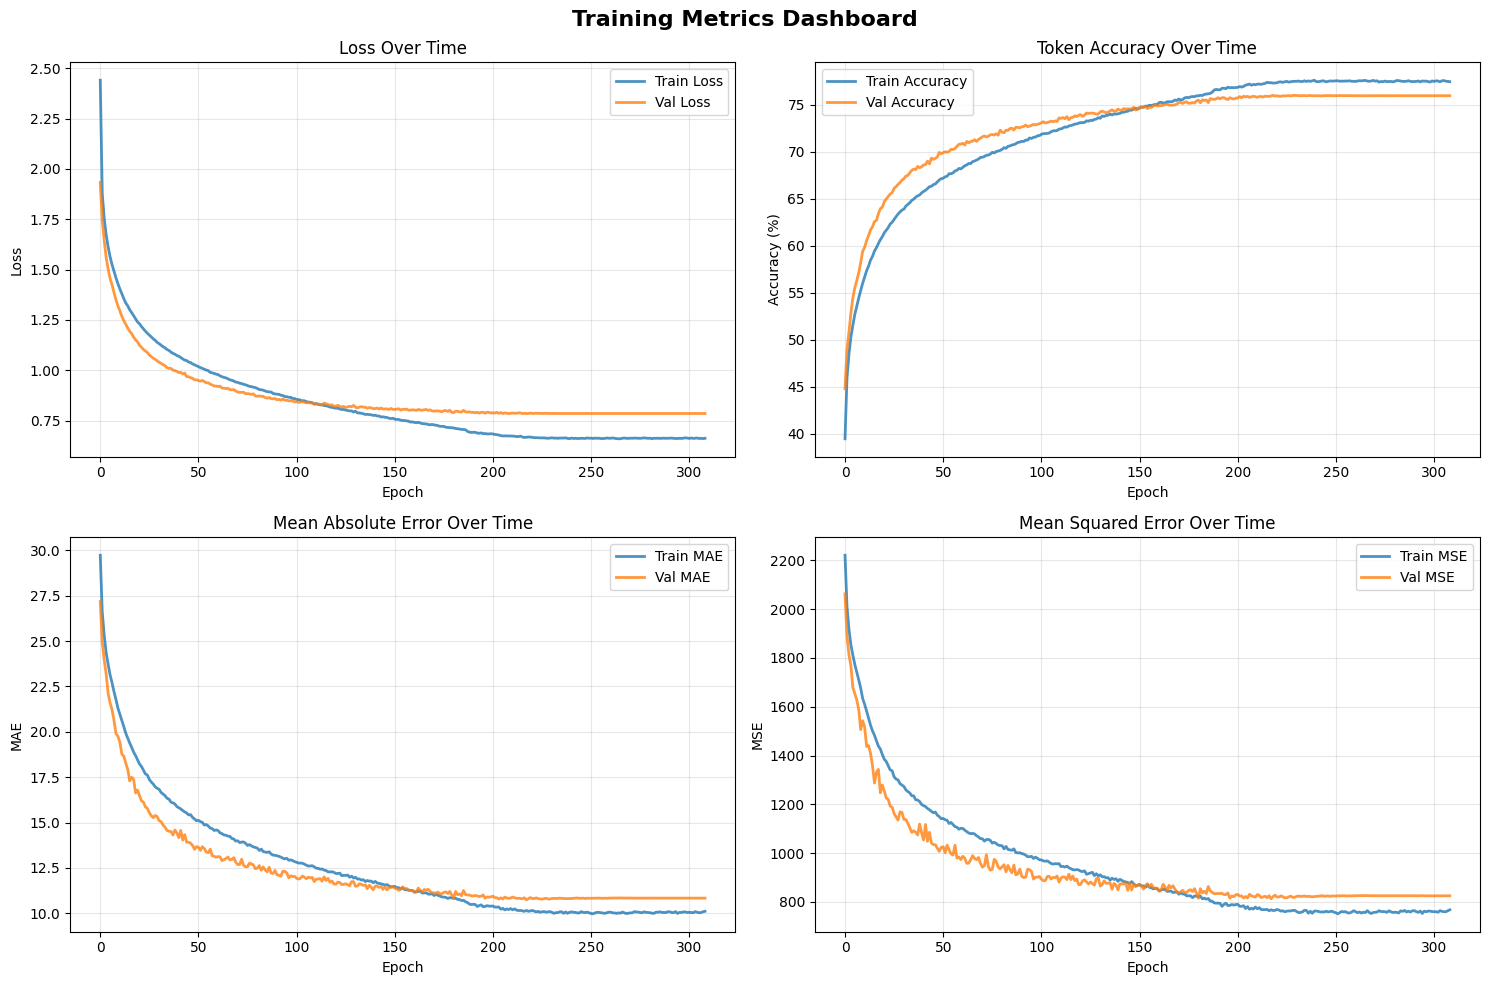


📈 Final Metrics Summary:
Final Train Loss: 0.6621
Final Val Loss: 0.7853
Final Train Accuracy: 77.48%
Final Val Accuracy: 75.98%
Final Train MAE: 10.1136
Final Val MAE: 10.8364
Final Train MSE: 767.4832
Final Val MSE: 825.0173

📂 Loading best model...

🎯 Training Summary:
Early stopped: True
Total epochs: 309
Best validation loss: 0.7845
✅ Model training was stopped early to prevent overfitting


In [17]:
num_epochs = 2000
# 7. Usage example
if __name__ == "__main__":
    # Prepare data with EOS tokens

    Y_with_eos = prepare_target_sequences(Y_properties)

    # Create data loaders
    def create_dataloaders(X, Y, batch_size, split_ratio=0.9):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.long)

        dataset = TensorDataset(X_tensor, Y_tensor)
        train_size = int(split_ratio * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        return train_loader, val_loader

    train_loader, val_loader = create_dataloaders(X_properties, Y_with_eos, batch_size)

    # Initialize model
    model = MolecularTransformer(
        property_dim=X_properties.shape[1],
        vocab_size=vocab_size,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model with early stopping
    trained_model, training_history = train_model(
        model, train_loader, val_loader, num_epochs, learning_rate, patience=100
    )

    # Print training summary
    print(f"\n🎯 Training Summary:")
    print(f"Early stopped: {training_history['early_stopped']}")
    print(f"Total epochs: {training_history['total_epochs']}")
    print(f"Best validation loss: {training_history['best_val_loss']:.4f}")

    # Additional analysis
    if training_history['early_stopped']:
        print(f"✅ Model training was stopped early to prevent overfitting")
    else:
        print(f"⚠️ Model completed all epochs - consider increasing patience or epochs")

In [22]:
print(device)

cuda


In [24]:
def generate_smiles(model, properties, temperature=1.0):
    """Generate a SMILES string from input molecular properties"""
    model.eval()
    with torch.no_grad():
        properties_tensor = torch.tensor([properties], dtype=torch.float32).to(device)
        generated_tokens_batch = model.generate(properties_tensor, temperature=temperature)

        generated_tokens = generated_tokens_batch[0].cpu().numpy()
        token_list = []

        for token_id in generated_tokens:
            if token_id in [sos_token_id]:
                continue
            if token_id in [eos_token_id, pad_token_id]:
                break
            token_list.append(idx_to_token.get(token_id, "<UNK>"))

        try:
            return detokenize_selfies(token_list)
        except:
            return None


def test_and_visualize(model, test_idx):
    """Generate SMILES from model and visualize both true and generated molecules"""
    test_props = X_properties[test_idx]
    print((test_props))
    true_token_ids = Y_properties[test_idx]
    true_tokens = [idx_to_token[idx] for idx in true_token_ids if idx not in [sos_token_id, eos_token_id, pad_token_id]]
    true_smiles = detokenize_selfies(true_tokens)

    generated_smiles = generate_smiles(model, test_props)

    print(f"True SMILES:      {true_smiles}")
    print(f"Generated SMILES: {generated_smiles}")

    # Visualize both molecules
    if true_smiles:
        print("\nTrue Molecule (3D):")
        view = visualize_smiles_3d(true_smiles)
        if view:
            view.show()

    if generated_smiles:
        print("\nGenerated Molecule (3D):")
        view = visualize_smiles_3d(generated_smiles)
        if view:
            view.show()


# Example: test and visualize molecule at index 3
test_and_visualize(trained_model, test_idx=109)
#[0.5648172  0.25       0.22222222 0.4        0.28836983 0.6       ]

[0.06435809 0.01724138 0.03141361 0.02352941 0.02757549 0.06698564]
True SMILES:      [H][C@]12CN(C[C@@]1([H])NCCC2)C3=C(F)C=C4C(=O)C(=CN(C5CC5)C4=C3OC)C(O)=O
Generated SMILES: CC1=CC=C(C2=NC3=CC(NC(=O)C4=CC([N+1](=O)[O-1])=CC=C4Cl)=CC=C3O2)C=C1

True Molecule (3D):


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Generated Molecule (3D):


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [53]:
import torch
import torch.nn as nn
import numpy as np
import math
import pickle
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors


# Model definition
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1)].transpose(0, 1)
        return self.dropout(x)

class MolecularTransformer(nn.Module):
    def __init__(self, property_dim, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout, max_seq_len=80):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.rnn_encoder = nn.GRU(input_size=property_dim, hidden_size=d_model, num_layers=1, batch_first=True, bidirectional=False)
        self.token_embed = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        self.output_projection = nn.Linear(d_model, vocab_size)

    def create_padding_mask(self, tokens):
        return (tokens == 0)  # pad_token_id = 0

    def create_causal_mask(self, size):
        return torch.triu(torch.ones(size, size), diagonal=1).bool()

    def generate(self, properties, max_len=80, temperature=1.0):
        if properties.dim() == 2:
            properties = properties.unsqueeze(1)

        _, hidden = self.rnn_encoder(properties)
        memory = hidden.transpose(0, 1)

        batch_size = properties.size(0)
        device = properties.device

        generated_tokens = torch.full((batch_size, 1), self.sos_token_id, dtype=torch.long, device=device)

        for _ in range(max_len - 1):
            token_embeds = self.token_embed(generated_tokens) * math.sqrt(self.d_model)
            token_embeds = self.pos_encoder(token_embeds)

            tgt_mask = self.create_causal_mask(generated_tokens.size(1)).to(device)
            tgt_padding_mask = self.create_padding_mask(generated_tokens)

            output = self.transformer_decoder(
                tgt=token_embeds,
                memory=memory.expand(batch_size, token_embeds.size(1), self.d_model),
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_padding_mask
            )

            logits = self.output_projection(output[:, -1, :])
            logits = logits / temperature
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

            generated_tokens = torch.cat([generated_tokens, next_token], dim=1)

            if (next_token == self.eos_token_id).all():
                break

        return generated_tokens

def min_max_normalize(data, min_vals, max_vals):
    denom = max_vals - min_vals
    denom[denom == 0] = 1.0
    return (data - min_vals) / denom

def tokens_to_smiles(tokens, idx_to_token):
    """Convert token indices to SMILES string"""
    selfies_tokens = []
    for token_id in tokens:
        if token_id in [0, vocab_info['sos_token_id'], vocab_info['eos_token_id']]:  # Skip special tokens
            continue
        selfies_tokens.append(idx_to_token[token_id])

    if not selfies_tokens:
        return None

    selfies_str = "".join(selfies_tokens)
    try:
        smiles = sf.decoder(selfies_str)
        return smiles
    except:
        return None

# Load model and vocabulary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('best_molecular_transformer.pth', map_location=device, weights_only=False)

# Load vocabulary
with open("vocab.pkl", "rb") as f:
    vocab_info = pickle.load(f)

# Model parameters (adjust if different)
d_model = 256
nhead = 8
num_layers = 3
dim_feedforward = 512
dropout = 0.1
property_dim = 6  # Number of molecular properties

# Get vocab size from checkpoint to ensure exact match
vocab_size = checkpoint['model_state_dict']['token_embed.weight'].shape[0]
model = MolecularTransformer(property_dim, vocab_size, d_model, nhead, num_layers, dim_feedforward, dropout)
model.sos_token_id = vocab_info['sos_token_id']
model.eos_token_id = vocab_info['eos_token_id']

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Get normalization parameters
min_vals = checkpoint['normalization_params']['min_vals']
max_vals = checkpoint['normalization_params']['max_vals']

# Test function
def test_molecule_generation(properties_array, temperature=1.0, max_len=80):
    """
    Generate molecules from molecular properties

    Args:
        properties_array: numpy array of shape (n_molecules, 6) with properties in order:
                         [MolecularWeight, NumHDonors, NumHAcceptors, NumRotatableBonds, TPSA, NumAtoms]
        temperature: sampling temperature (1.0 = normal, <1.0 = more conservative, >1.0 = more diverse)
        max_len: maximum sequence length

    Returns:
        List of generated SMILES strings
    """
    # Normalize properties
    normalized_props = min_max_normalize(properties_array, min_vals, max_vals)

    # Convert to tensor
    props_tensor = torch.tensor(normalized_props, dtype=torch.float32).to(device)

    with torch.no_grad():
        generated_tokens = model.generate(props_tensor, max_len=max_len, temperature=temperature)

    # Convert tokens to SMILES
    generated_smiles = []
    for i in range(generated_tokens.size(0)):
        tokens = generated_tokens[i].cpu().numpy()
        smiles = tokens_to_smiles(tokens, vocab_info['idx_to_token'])
        view = visualize_smiles_3d(smiles)
        if view:
            view.show()
        generated_smiles.append(smiles)

    return generated_smiles

# Example usage
if __name__ == "__main__":
    # Example: Generate molecules with specific properties
    # Properties order: [MolecularWeight, NumHDonors, NumHAcceptors, NumRotatableBonds, TPSA, NumAtoms]

    test_properties = np.array([
       [350.39, 2, 3, 4, 70, 35]   # Small drug-like molecule {molwt, HBD, HBA, number of rotatable bonds,TPSA NUmber of atoms}
    ])

    print("Generating molecules from properties...")
    generated_smiles = test_molecule_generation(test_properties, temperature=1.0)


    for i, (props, smiles) in enumerate(zip(test_properties, generated_smiles)):
        print(f"\nMolecule {i+1}:")
        print(f"Input properties: MW={props[0]}, HD={props[1]}, HA={props[2]}, RB={props[3]}, TPSA={props[4]}, Atoms={props[5]}")
        print(f"Generated SMILES: {smiles}")

        # Validate generated SMILES
        if smiles:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                print("✅ Valid molecule generated")
                # Compute properties
                mol_weight = Descriptors.MolWt(mol)
                hbd = rdMolDescriptors.CalcNumHBD(mol)
                hba = rdMolDescriptors.CalcNumHBA(mol)
                rb=Lipinski.NumRotatableBonds(mol),
                tpsa = rdMolDescriptors.CalcTPSA(mol)
                num_atoms = mol.GetNumAtoms()
                
                # Print results
                print(f"Molecular Weight: {mol_weight:.2f}")
                print(f"H-bond Donors (HBD): {hbd}")
                print(f"H-bond Acceptors (HBA): {hba}")
                print(f"Rotatable bonds: {rb}")
                print(f"Topological Polar Surface Area (TPSA): {tpsa:.2f}")
                print(f"Number of Atoms: {num_atoms}")
            else:
                print("❌ Invalid SMILES generated")
        else:
            print("❌ No SMILES generated")

Generating molecules from properties...


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


Molecule 1:
Input properties: MW=350.39, HD=2.0, HA=3.0, RB=4.0, TPSA=70.0, Atoms=35.0
Generated SMILES: C1C=C(C)N(CC2=CC=C(C3=CC=CC=C3C(=O)O)C=C2)C=CC=C1C(=O)N4CCCCC4C=C
✅ Valid molecule generated
Molecular Weight: 468.60
H-bond Donors (HBD): 1
H-bond Acceptors (HBA): 3
Rotatable bonds: (6,)
Topological Polar Surface Area (TPSA): 60.85
Number of Atoms: 35
